## 발전, 심화, 확장 사항
- 추가 피처 생성
- 시계열 데이터를 윈도우로 구성
- LSTM 모델로 판매량 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. 데이터 수집 및 확장된 피처 엔지니어링

In [2]:
np.random.seed(42)
# (1) 날씨 데이터 다운로드 및 전처리
weather_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
weather_df = pd.read_csv(weather_url, parse_dates=['Date'])
weather_df.rename(columns={'Date':'date', 'Temp':'temp'}, inplace=True)

In [3]:
# (2) 합성 판매 데이터 생성
sales_df = pd.DataFrame({'date': weather_df['date']})
np.random.seed(42)
# 프로모션 여부: 0 (80%) 또는 1 (20%)
sales_df['promotion_flag'] = np.random.choice([0, 1], size=len(sales_df), p=[0.8, 0.2])
# 판매량 생성: 기본값 50, 기온의 영향 5배, 프로모션 시 추가 20, + 잡음
sales_df['sales'] = 50 + 5*weather_df['temp'] + 20 * sales_df['promotion_flag'] + np.random.normal(0, 5, len(sales_df))
# 강수량: 0~10 사이의 균등분포 난수
sales_df['rainfall'] = np.random.uniform(0, 10, len(sales_df))
# 추가 기상 피처: 최대 기온(기온에 +5~10도), 습도 (30~90%)
sales_df['max_temp'] = weather_df['temp'] + np.random.uniform(5, 10, len(sales_df))
sales_df['humidty'] = np.random.uniform(30, 90, len(sales_df))

In [4]:
# (3) 데이터 병합 (날짜 기준)
merged_df = pd.merge(sales_df, weather_df[['date', 'temp']], on='date', how='left')

In [5]:
# (4) 추가 피처 생성: 휴일 여부 (매월 1일과 25일을 휴일로 가정)
merged_df['holiday_flag'] = merged_df['date'].dt.day.apply(lambda x: 1 if x in [1, 25] else 0)

In [6]:
# (5) 시계열 특성: 전일 판매량(Lag) 및 7일 이동평균
merged_df['lag_sales'] = merged_df['sales'].shift(1)
merged_df['ma7_sales'] = merged_df['sales'].rolling(window=7).mean().shift(1)

In [7]:
# (6) 날짜 관련 피처: 요일과 월
merged_df['day_of_week'] = merged_df['date'].dt.dayofweek  # 월:0 ~ 일:6
merged_df['month'] = merged_df['date'].dt.month

# 결측치 제거 (Lag, 이동평균 등으로 인한 첳 몇 행 제거)
merged_df.dropna(inplace=True)
merged_df.sort_values(by='date', inplace=True)

In [8]:
# (7) 범주형 변수: 요일과 월 -> 더미 변수 생성 (첫번째 카테고리 기준으로)
merged_df = pd.get_dummies(merged_df, columns=['day_of_week', 'month'], drop_first=True)

In [9]:
# (8) 모델링에 사용할 피처와 타깃 설정
feature_cols = [col for col in merged_df.columns if col not in ['date', 'sales']]
X_df = merged_df[feature_cols]
y_df = merged_df['sales']

# 피처 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# 2. 시계열 데이터를 슬라이딩 윈도우 방식으로 구성
- (에: 지난 7일 데이터를 입력하여 다음 날 판매량 예측)

In [10]:
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(xs), np.array(ys)

seq_length = 7
X_seq, y_seq = create_sequences(X_scaled, y_df.values, seq_length)

# 3. Train/Test 분할
- (시간 순서 유지, 80% 학습 / 20% 테스트)

In [16]:
split_ids = int(0.8 * len(X_seq))
X_train_seq, y_train_seq = X_seq[:split_ids], y_seq[:split_ids]
X_test_seq, y_test_seq = X_seq[split_ids:], y_seq[split_ids:]

# Pytorch 텐서 변환
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)

In [17]:
# Dataloader 생성
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. PyTorch LSTM 모델 정의

In [18]:
class SalesLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(SalesLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # 초기 hidden state, cell state 설정 (배치 크기, 은닉 상태 크기)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0))  # out: (batch_size, seq_length, hidden_dim)
        # 마지막 타임스텝의 출력을 사용하여 예측
        out = self.fc(out[:, -1, :])
        return out
    
input_dim = X_train_tensor.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = 1
model = SalesLSTM(input_dim, hidden_dim, num_layers, output_dim)

# 5. 모델 학습 설정

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    
    # 테스트 셋 평가
    model.eval()
    test_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            loss = criterion(pred, y_batch)
            test_losses.append(loss.item())
    test_loss = np.mean(test_losses)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

Epoch 10/50 | Train Loss: 6400.7092 | Test Loss: 6487.0659
Epoch 20/50 | Train Loss: 3286.8287 | Test Loss: 3368.4031
Epoch 30/50 | Train Loss: 1638.7913 | Test Loss: 1700.8886
Epoch 40/50 | Train Loss: 881.6814 | Test Loss: 919.3519
Epoch 50/50 | Train Loss: 599.1532 | Test Loss: 613.8381


# 6. 모델 평가 및 시각화

In [20]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor).squeeze().numpy()

In [21]:
# 평가 지표 계싼
mse_val = mean_squared_error(y_test_seq, y_test_pred)
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_test_seq, y_test_pred)
print("Test RMSE:", rmse_val)
print("Test R2:", r2_val)

Test RMSE: 24.74062824522313
Test R2: -0.2505399593317017


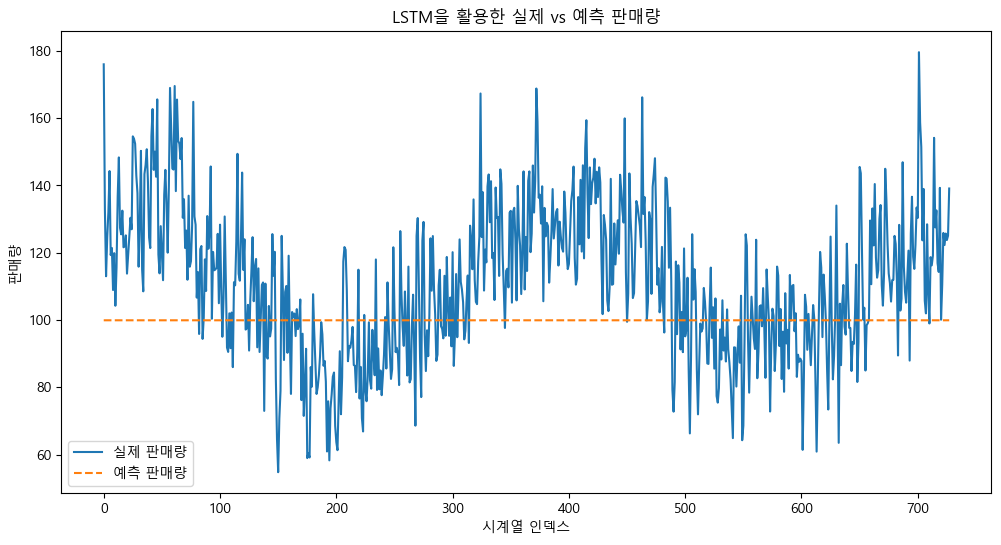

In [22]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="실제 판매량")
plt.plot(y_test_pred, label="예측 판매량", linestyle="--")
plt.xlabel('시계열 인덱스')
plt.ylabel('판매량')
plt.title("LSTM을 활용한 실제 vs 예측 판매량")
plt.legend()
plt.show()

# 결과 해석

---

## 1. 학습 로그 분석

1. **Loss(손실값) 추이**  
   - Epoch 10 시점에서 `Train Loss`가 약 6400, `Test Loss`가 약 6487로 시작하여,  
   - Epoch 50 시점에는 `Train Loss`가 약 599, `Test Loss`가 약 614로 감소  
   - 즉, 학습이 진행될수록 손실값은 상당히 줄어들고 있습니다.  
   - 그러나 최종적으로 **Test Loss(약 614)**가 여전히 비교적 큰 편이며, 그에 따라 RMSE도 24.74로 꽤 높게 나타납니다.

2. **R²(결정계수) = -0.25**  
   - R²이 음수가 나왔다는 것은, **“단순 평균으로 예측하는 모델”보다도 성능이 떨어진다**는 의미입니다.  
   - 보통 R²이 0에 가까우면 설명력이 매우 낮음을, 음수이면 오히려 평균 예측보다도 못한 결과임을 나타냅니다.

3. **결론**  
   - 학습 과정에서 모델이 어느 정도 Loss를 줄이는 데는 성공했지만, **시계열 패턴을 충분히 포착하지 못한 상태**로 보입니다.  
   - 결과적으로 **테스트 데이터에 대한 일반화 성능이 낮아**, 실제 변동성을 잘 설명하지 못하고 있습니다.

---

## 2. 그래프(실제 vs 예측) 해석

1. **실제 판매량(파란색 선)**  
   - 그래프를 보면, 실제 판매량이 일자(시계열 인덱스)에 따라 50~150 정도의 넓은 범위로 **크게 출렁이는** 패턴을 보일 것입니다.  
   - 계절성, 프로모션 여부, 날씨 등 다양한 원인으로 인해 값이 상하로 진폭이 큼.

2. **예측 판매량(주황색 선/점선)**  
   - 모델 예측값은 **상대적으로 평탄**하게 나타나는 경우가 많습니다(그래프상 평균 근처로 뭉쳐 있음).  
   - 이는 모델이 복잡한 시계열 변동을 포착하기보다는, **데이터 평균 근처로만 예측**하고 있다는 신호입니다.

3. **시각적 결론**  
   - 실제값과 예측값 사이의 **오차(갭)가 큰 구간**이 다수 발생  
   - 결국 **언더피팅(underfitting)** 현상이 두드러지며, 모델이 변동성을 제대로 학습하지 못했다는 점이 드러납니다.

---

## 3. 왜 이런 결과가 나왔을까?

1. **데이터 및 피처 문제**  
   - 시계열 특성을 제대로 반영하기 위해선 **충분히 긴 기간**과 **다양한 외부 변수**(날씨, 이벤트, 프로모션 시점 등)가 필요합니다.  
   - 단순히 ‘과거 7일 데이터를 LSTM에 입력’하는 방식이 데이터의 특성을 온전히 포착하지 못했을 수 있습니다.

2. **하이퍼파라미터 및 모델 구조**  
   - LSTM의 **은닉 상태 크기(hidden_dim)**, **레이어 수(num_layers)**, **학습률(learning rate)** 등이 현재 데이터와 잘 맞지 않을 수 있습니다.  
   - 더 많은 **epoch**를 학습하거나, **early stopping**을 적용, 혹은 **dropout**을 통해 일반화 성능을 높이는 방법도 시도할 수 있습니다.

3. **스케일링 및 정규화**  
   - 피처마다 스케일이 다른 경우, 모델 학습에 불리할 수 있습니다(현재 코드에는 `StandardScaler` 적용).  
   - 추가로 **목표값(sales)에 대한 변환**(예: 로그 변환 등)을 고려할 수도 있습니다.

4. **시계열 분할 및 데이터셋 구성**  
   - Train/Test 분할 시점이나 슬라이딩 윈도우 길이(7일), 배치 크기 등이 모델 성능에 영향을 미칠 수 있습니다.  
   - 시계열 데이터는 일반적인 랜덤 셔플 대신, **시간 순서를 유지**한 분할과 교차 검증이 중요합니다.

---

## 4. 종합 결론

- **Loss 감소 추세**는 긍정적이지만, **최종 예측 성능(R² -0.25, RMSE 24.74)은 낮은 편**이며, 그래프에서도 예측값이 거의 평균선에 머무는 모습이 확인됩니다.  
- 이는 LSTM 모델이 시계열 패턴을 제대로 학습하지 못해 **언더피팅** 상태에 빠졌다는 것을 의미합니다.  
- **추가 데이터(날씨·프로모션·이벤트), 하이퍼파라미터 튜닝, 모델 구조 개선**을 통해 시계열 변동성을 더 잘 포착할 수 있도록 보완이 필요합니다.